In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import numpy as np

from torch.utils.data import DataLoader
import torch.utils.data as data_utils

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

from datasets import get_dataset

from loss_fns import LogisticRegression, NLLSQ

from sklearn.datasets import load_svmlight_file


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def logistic_reg(w, X, y):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))

def nllsq(w, X, y):
    return torch.mean( ( y - (1/(1 + torch.exp(-X @ w ))) )**2 )

def rademacher_old(weights):
    return torch.round(torch.rand_like(weights)) * 2 - 1

In [6]:
loss_fn = "logistic"

if loss_fn == "logistic":
    F = logistic_reg
elif loss_fn == "nllsq":
    F = nllsq

In [28]:
batch_size = 8
# dataset_name = "covtype.libsvm.binary"
dataset_name = "colon-cancer"
percentage = 1.0
scale = 0

STEPS = 100
# train_dataloader, train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)
datasets_path = os.getenv("DATASETS_DIR")
trainX, trainY = load_svmlight_file(f"{datasets_path}/{dataset_name}")
sample = np.random.choice(trainX.shape[0], round(trainX.shape[0] * percentage), replace=False)

assert sample.shape == np.unique(sample).shape

trainX = trainX[sample]
trainY = trainY[sample]

train_data = torch.tensor(trainX.toarray(), dtype=torch.float)
train_target = torch.tensor(trainY, dtype=torch.float)

if scale != 0:
    r1 = -scale
    r2 = scale
    scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
    scaling_vec = torch.pow(torch.e, scaling_vec)
    train_data = scaling_vec * train_data

train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

# SGD with $lr=1e^{-1}$

In [29]:
from torch.optim import SGD

w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

criterion = LogisticRegression(w)

hist_sgd = []

loss = criterion(train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)
hist_sgd.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

optimizer = SGD([w], lr=1e-1)


for step in range(STEPS):
    
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)

        for param in w:
            param.grad = None

        loss = criterion(batch_data, batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)

        with torch.no_grad():
            w.sub_(0.01 * g)


    train_loss = criterion(train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(train_loss, w)
 
    print(f"Loss: {train_loss.item()} | GradNorm^2: {torch.linalg.norm(g).item() ** 2 }")

    hist_sgd.append([train_loss.item(), torch.linalg.norm(g).item() ** 2])   

Loss: 0.32029372453689575 | GradNorm^2: 3.6650619368134016
Loss: 0.23046132922172546 | GradNorm^2: 1.5066054408379301
Loss: 0.18836034834384918 | GradNorm^2: 1.2205053056209323
Loss: 0.15790621936321259 | GradNorm^2: 1.2664437425612505
Loss: 0.12598086893558502 | GradNorm^2: 0.5891675767802695
Loss: 0.10638578236103058 | GradNorm^2: 0.3532586301229266
Loss: 0.0913609117269516 | GradNorm^2: 0.18113497290883718
Loss: 0.08280700445175171 | GradNorm^2: 0.18525628079579803
Loss: 0.07293339818716049 | GradNorm^2: 0.08896630080574042
Loss: 0.06982104480266571 | GradNorm^2: 0.19125631036406876
Loss: 0.06094629317522049 | GradNorm^2: 0.0749063222323807
Loss: 0.056129761040210724 | GradNorm^2: 0.05568329214016843
Loss: 0.052861813455820084 | GradNorm^2: 0.06805970825385899
Loss: 0.048657435923814774 | GradNorm^2: 0.0391922164436318
Loss: 0.04563436284661293 | GradNorm^2: 0.034020994633652046
Loss: 0.0432078056037426 | GradNorm^2: 0.03557899447035795
Loss: 0.04059280827641487 | GradNorm^2: 0.0259

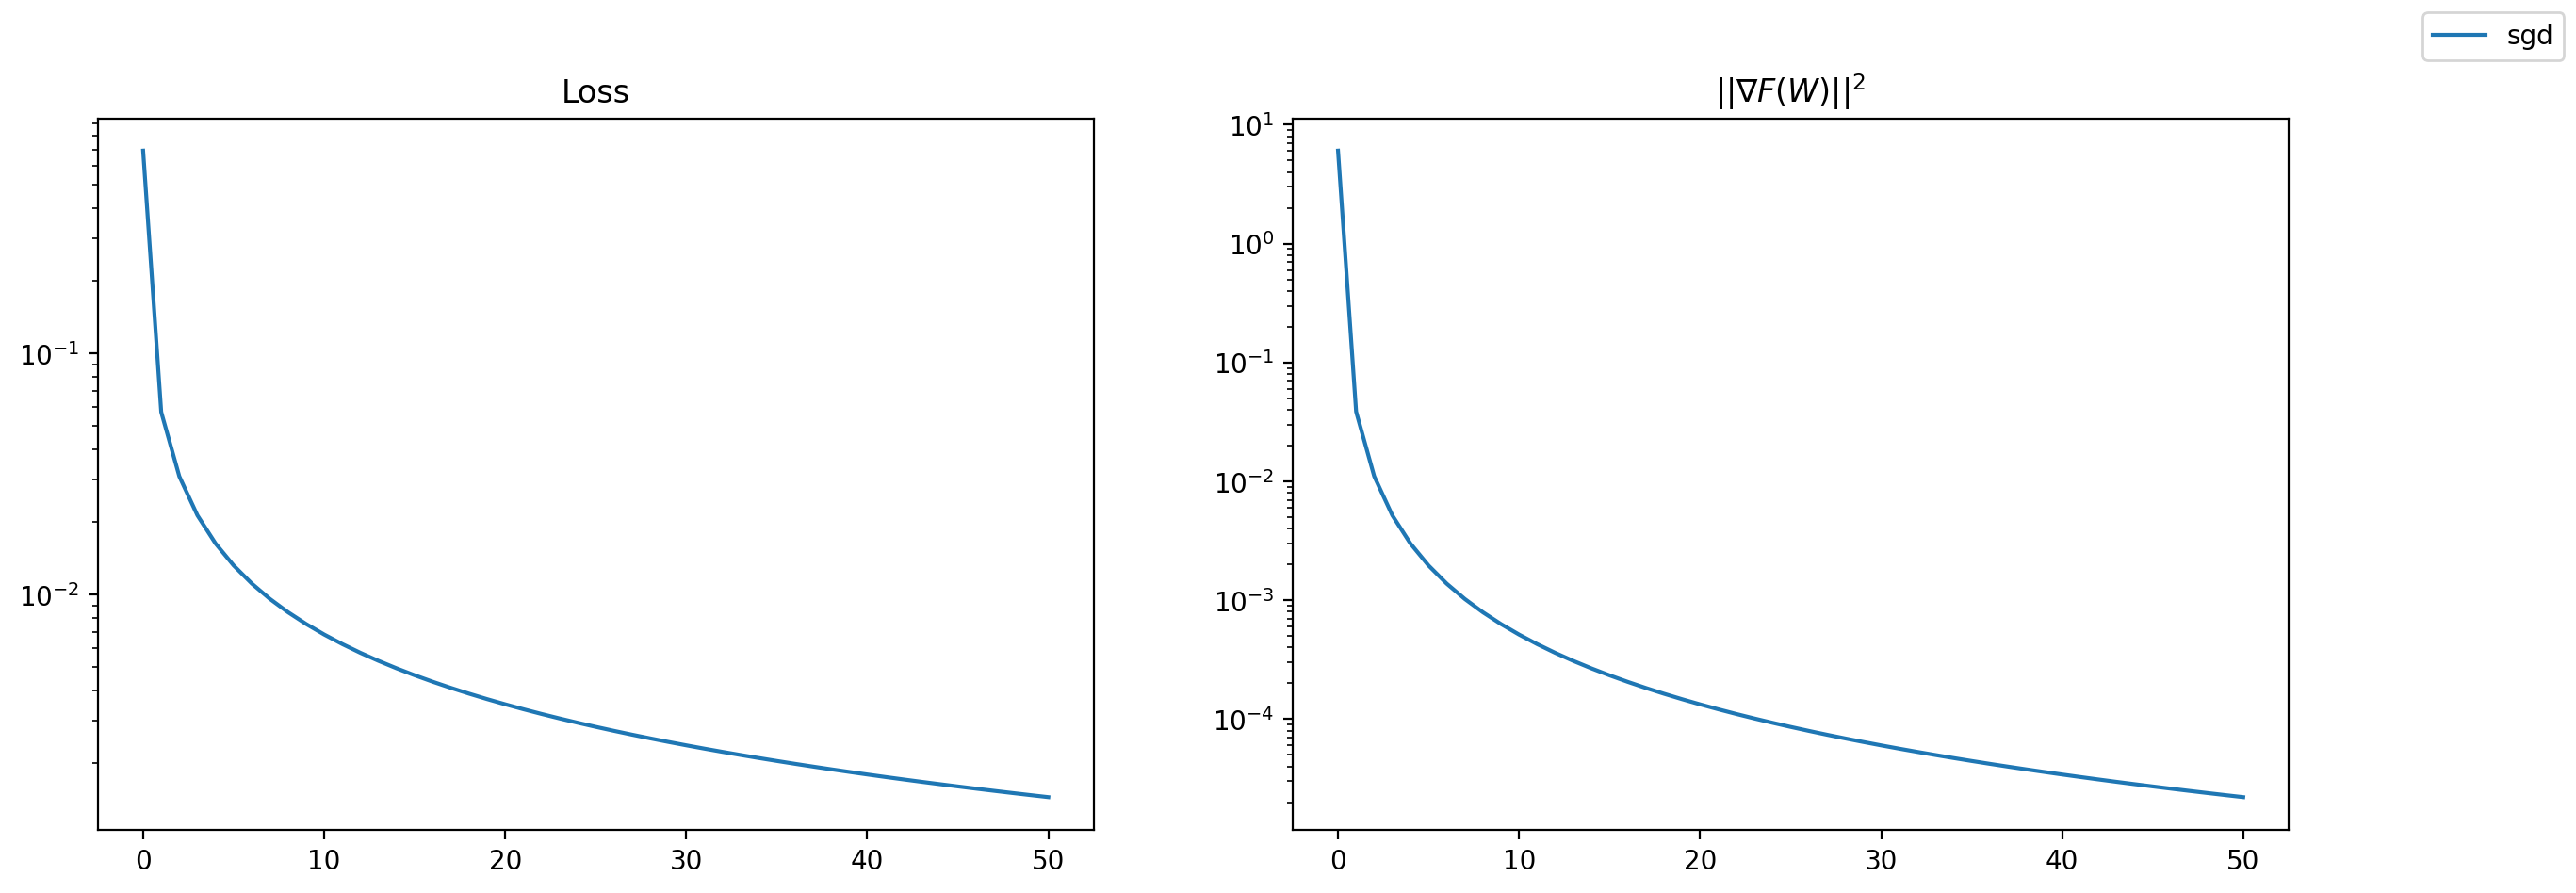

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)
ax1.semilogy([x[0] for x in hist_sgd])
ax1.set_title("Loss")

ax2.semilogy([x[1] for x in hist_sgd])
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2$")

fig.legend(["sgd"])

# SPS

In [46]:
batch_size = 8
# dataset_name = "covtype.libsvm.binary"
dataset_name = "colon-cancer"
percentage = 1.0
scale = 0

STEPS = 100
# train_dataloader, train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)
datasets_path = os.getenv("DATASETS_DIR")
trainX, trainY = load_svmlight_file(f"{datasets_path}/{dataset_name}")
sample = np.random.choice(trainX.shape[0], round(trainX.shape[0] * percentage), replace=False)

assert sample.shape == np.unique(sample).shape

trainX = trainX[sample]
trainY = trainY[sample]

train_data = torch.tensor(trainX.toarray(), dtype=torch.float)
train_target = torch.tensor(trainY, dtype=torch.float)

if scale != 0:
    r1 = -scale
    r2 = scale
    scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
    scaling_vec = torch.pow(torch.e, scaling_vec)
    train_data = scaling_vec * train_data

train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)

w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

loss = F(w, train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)

hist_sps = []
hist_sps.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

for step in range(STEPS):
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        loss = F(w, X=batch_data, y=batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)
        grad_norm_sq = torch.linalg.norm(g) ** 2
        precond = loss / grad_norm_sq

        with torch.no_grad():
            w.sub_(precond * g)

    loss = F(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

    hist_sps.append([loss.item(), (torch.linalg.norm(g) ** 2 ).item()])

Loss: 0.2905018627643585 | GradNorm^2: 1.8504106998443604
Loss: 0.21648333966732025 | GradNorm^2: 1.2260630130767822
Loss: 0.14102567732334137 | GradNorm^2: 0.4886217415332794
Loss: 0.10194359719753265 | GradNorm^2: 0.34543725848197937
Loss: 0.07847297936677933 | GradNorm^2: 0.185649111866951
Loss: 0.0636579841375351 | GradNorm^2: 0.25520098209381104
Loss: 0.05558899790048599 | GradNorm^2: 0.3529839813709259
Loss: 0.03824177011847496 | GradNorm^2: 0.07274925708770752
Loss: 0.03096003085374832 | GradNorm^2: 0.04318581521511078
Loss: 0.026693955063819885 | GradNorm^2: 0.05187482386827469
Loss: 0.029608186334371567 | GradNorm^2: 0.17399412393569946
Loss: 0.019383439794182777 | GradNorm^2: 0.026822952553629875
Loss: 0.01563285104930401 | GradNorm^2: 0.020336851477622986
Loss: 0.012555727735161781 | GradNorm^2: 0.006771044805645943
Loss: 0.01221431978046894 | GradNorm^2: 0.030769171193242073
Loss: 0.012208864092826843 | GradNorm^2: 0.04477330669760704
Loss: 0.010183591395616531 | GradNorm^2

In [42]:
batch_size = 8
# dataset_name = "covtype.libsvm.binary"
dataset_name = "colon-cancer"
percentage = 1.0
scale = 10

STEPS = 100
# train_dataloader, train_data, train_target = get_dataset(dataset_name, batch_size, scale_data)
datasets_path = os.getenv("DATASETS_DIR")
trainX, trainY = load_svmlight_file(f"{datasets_path}/{dataset_name}")
sample = np.random.choice(trainX.shape[0], round(trainX.shape[0] * percentage), replace=False)

assert sample.shape == np.unique(sample).shape

trainX = trainX[sample]
trainY = trainY[sample]

train_data = torch.tensor(trainX.toarray(), dtype=torch.float)
train_target = torch.tensor(trainY, dtype=torch.float)

if scale != 0:
    r1 = -scale
    r2 = scale
    scaling_vec = (r1 - r2) * torch.rand(train_data.shape[1]) + r2
    scaling_vec = torch.pow(torch.e, scaling_vec)
    train_data = scaling_vec * train_data

train_load = data_utils.TensorDataset(train_data, train_target)
train_dataloader = DataLoader(train_load, batch_size=batch_size, shuffle=True)







w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

loss = F(w, train_data.to(device), train_target.to(device))
g, = torch.autograd.grad(loss, w, create_graph=True)

hist_psps = []
hist_psps.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])

for step in range(STEPS):
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        batch_data = batch_data.to(device)
        batch_target = batch_target.to(device)
        loss = F(w, X=batch_data, y=batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)
        D_inv = (1 / scaling_vec).to(device)
        grad_norm_sq = torch.dot(g, D_inv * g)
        precond = (loss / grad_norm_sq) * D_inv

        with torch.no_grad():
            w.sub_(precond * g)

    loss = F(w, train_data.to(device), train_target.to(device))
    g, = torch.autograd.grad(loss, w, create_graph=True)
    print(f"Loss: {loss.item()} | GradNorm^2: {torch.dot(g, D_inv * g).item()}")

    hist_psps.append([loss.item(), torch.dot(g, D_inv * g).item()])

Loss: 0.5838906764984131 | GradNorm^2: 11.277321815490723
Loss: 0.49408969283103943 | GradNorm^2: 29.26570701599121
Loss: 0.5101823806762695 | GradNorm^2: 8.175861358642578
Loss: 0.8792532086372375 | GradNorm^2: 613.06591796875
Loss: 0.4452519118785858 | GradNorm^2: 5.355797290802002
Loss: 1.0224393606185913 | GradNorm^2: 14.026838302612305
Loss: 1.580463171005249 | GradNorm^2: 852.7127685546875
Loss: 0.6580398678779602 | GradNorm^2: 18.671951293945312
Loss: 0.46420764923095703 | GradNorm^2: 6.555405139923096
Loss: 0.5105389952659607 | GradNorm^2: 5.984512805938721
Loss: 0.5968660116195679 | GradNorm^2: 162.15219116210938
Loss: 0.4404362142086029 | GradNorm^2: 6.649663925170898
Loss: 0.7742243409156799 | GradNorm^2: 17.376955032348633
Loss: 0.55300372838974 | GradNorm^2: 147.99842834472656
Loss: 0.6193801164627075 | GradNorm^2: 16.29936408996582
Loss: 0.6833970546722412 | GradNorm^2: 13.607328414916992
Loss: 0.727436363697052 | GradNorm^2: 163.48097229003906
Loss: 0.6612486243247986 | 

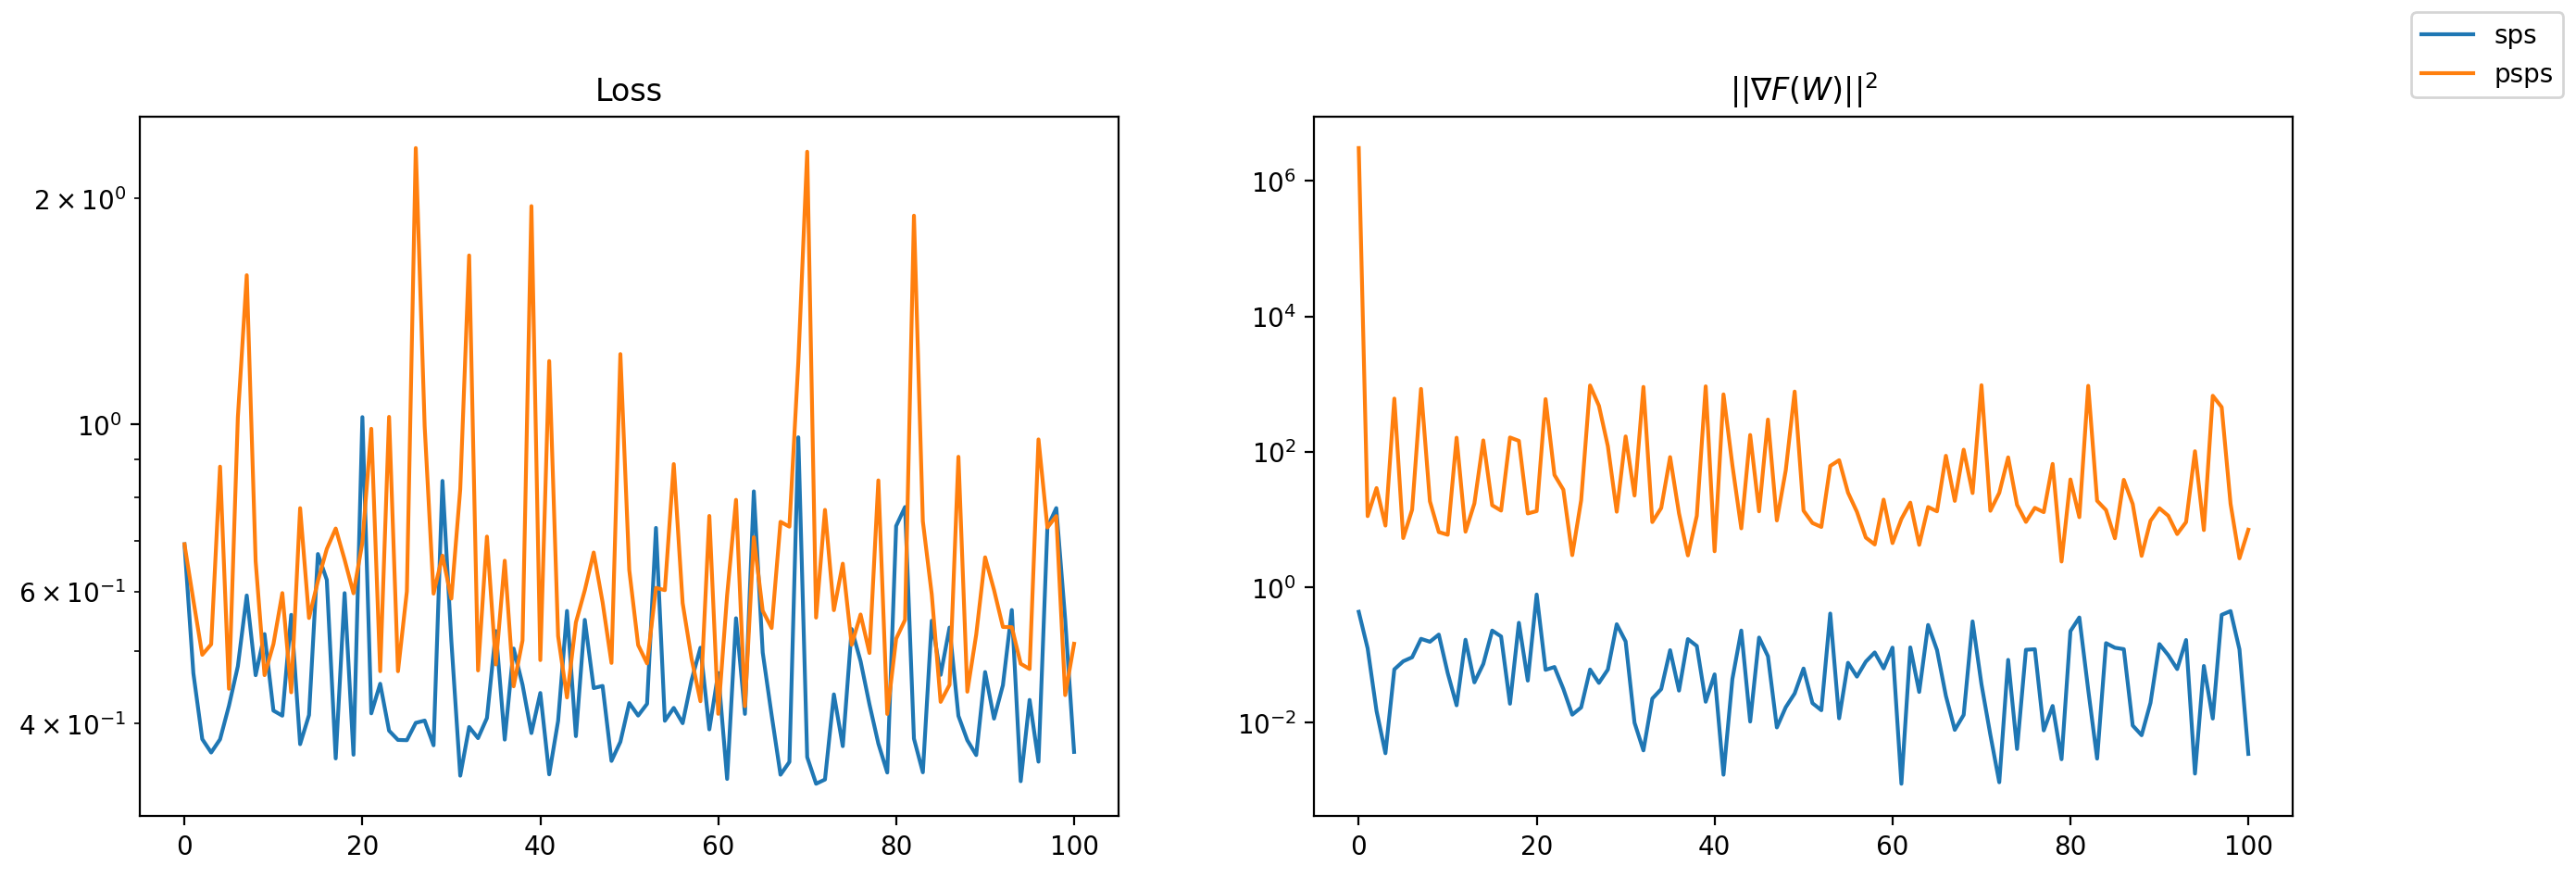

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)
ax1.semilogy([x[0] for x in hist_sps])
ax1.semilogy([x[0] for x in hist_psps])
ax1.set_title("Loss")

ax2.semilogy([x[1] for x in hist_sps])
ax2.semilogy([x[1] for x in hist_psps])

ax2.set_title(r"$\|\| \nabla F(W) \|\|^2$")

fig.legend(["sps", "psps"])

In [86]:
def diag_estimate_old(weights, grad, iters):
    Ds = []
    for j in range(iters):
        z = rademacher_old(weights)
        with torch.no_grad():
            hvp = torch.autograd.grad(grad, weights, grad_outputs=z, retain_graph=True)[0]
        Ds.append((hvp*z))

    return torch.mean(torch.stack(Ds), 0)

# SPS-D

In [88]:
alpha=0.1
beta=0.999

w = torch.zeros(train_data.shape[1], device=device).requires_grad_()
hist_sps_d = []

loss = F(w)
g, = torch.autograd.grad(loss, w, create_graph=True)

print(f"Loss: {loss.item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")
hist_sps_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item()])


Dk = diag_estimate_old(w, g, 100)

for step in range(STEPS):
    
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        loss = F(w, X=batch_data, y=batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)

        vk = diag_estimate_old(w, g, 1)

        # Smoothing and Truncation 
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha

        Dk_hat_inv = 1 / Dk_hat

        gnorm = (g * Dk_hat_inv).dot(g)

        if gnorm.item() < 1e-13:
            continue 

        precond = (loss / (gnorm)) * Dk_hat_inv
        
        with torch.no_grad():
            w.sub_(precond * g)


    print(f"Loss: {F(w).item()} | GradNorm^2: {(torch.linalg.norm(g) ** 2 ).item()}")

    hist_sps_d.append([F(w).item(), (torch.linalg.norm(g) ** 2 ).item()])


Loss: 0.6931472420692444 | GradNorm^2: 6.057377338409424
Loss: 4.049945712125691e-09 | GradNorm^2: 6.975179524818182e-15
Loss: 4.049945712125691e-09 | GradNorm^2: 1.9840779318987543e-16
Loss: 1.61410884658153e-09 | GradNorm^2: 4.124853782666002e-16
Loss: 1.61410884658153e-09 | GradNorm^2: 1.9073313205726964e-16
Loss: 1.61410884658153e-09 | GradNorm^2: 3.7456025229434226e-17
Loss: 1.61410884658153e-09 | GradNorm^2: 3.68820432788947e-16
Loss: 1.61410884658153e-09 | GradNorm^2: 1.0580802057877738e-15
Loss: 1.61410884658153e-09 | GradNorm^2: 1.0465430876505782e-15
Loss: 1.61410884658153e-09 | GradNorm^2: 4.934017541209788e-17
Loss: 1.61410884658153e-09 | GradNorm^2: 1.3716700140696818e-15
Loss: 1.61410884658153e-09 | GradNorm^2: 1.6322237543317682e-16
Loss: 7.336858343087727e-10 | GradNorm^2: 2.2120897383534044e-17
Loss: 7.336858343087727e-10 | GradNorm^2: 7.456747017673601e-18
Loss: 7.336858343087727e-10 | GradNorm^2: 3.920318619310138e-17
Loss: 7.336858343087727e-10 | GradNorm^2: 5.88248

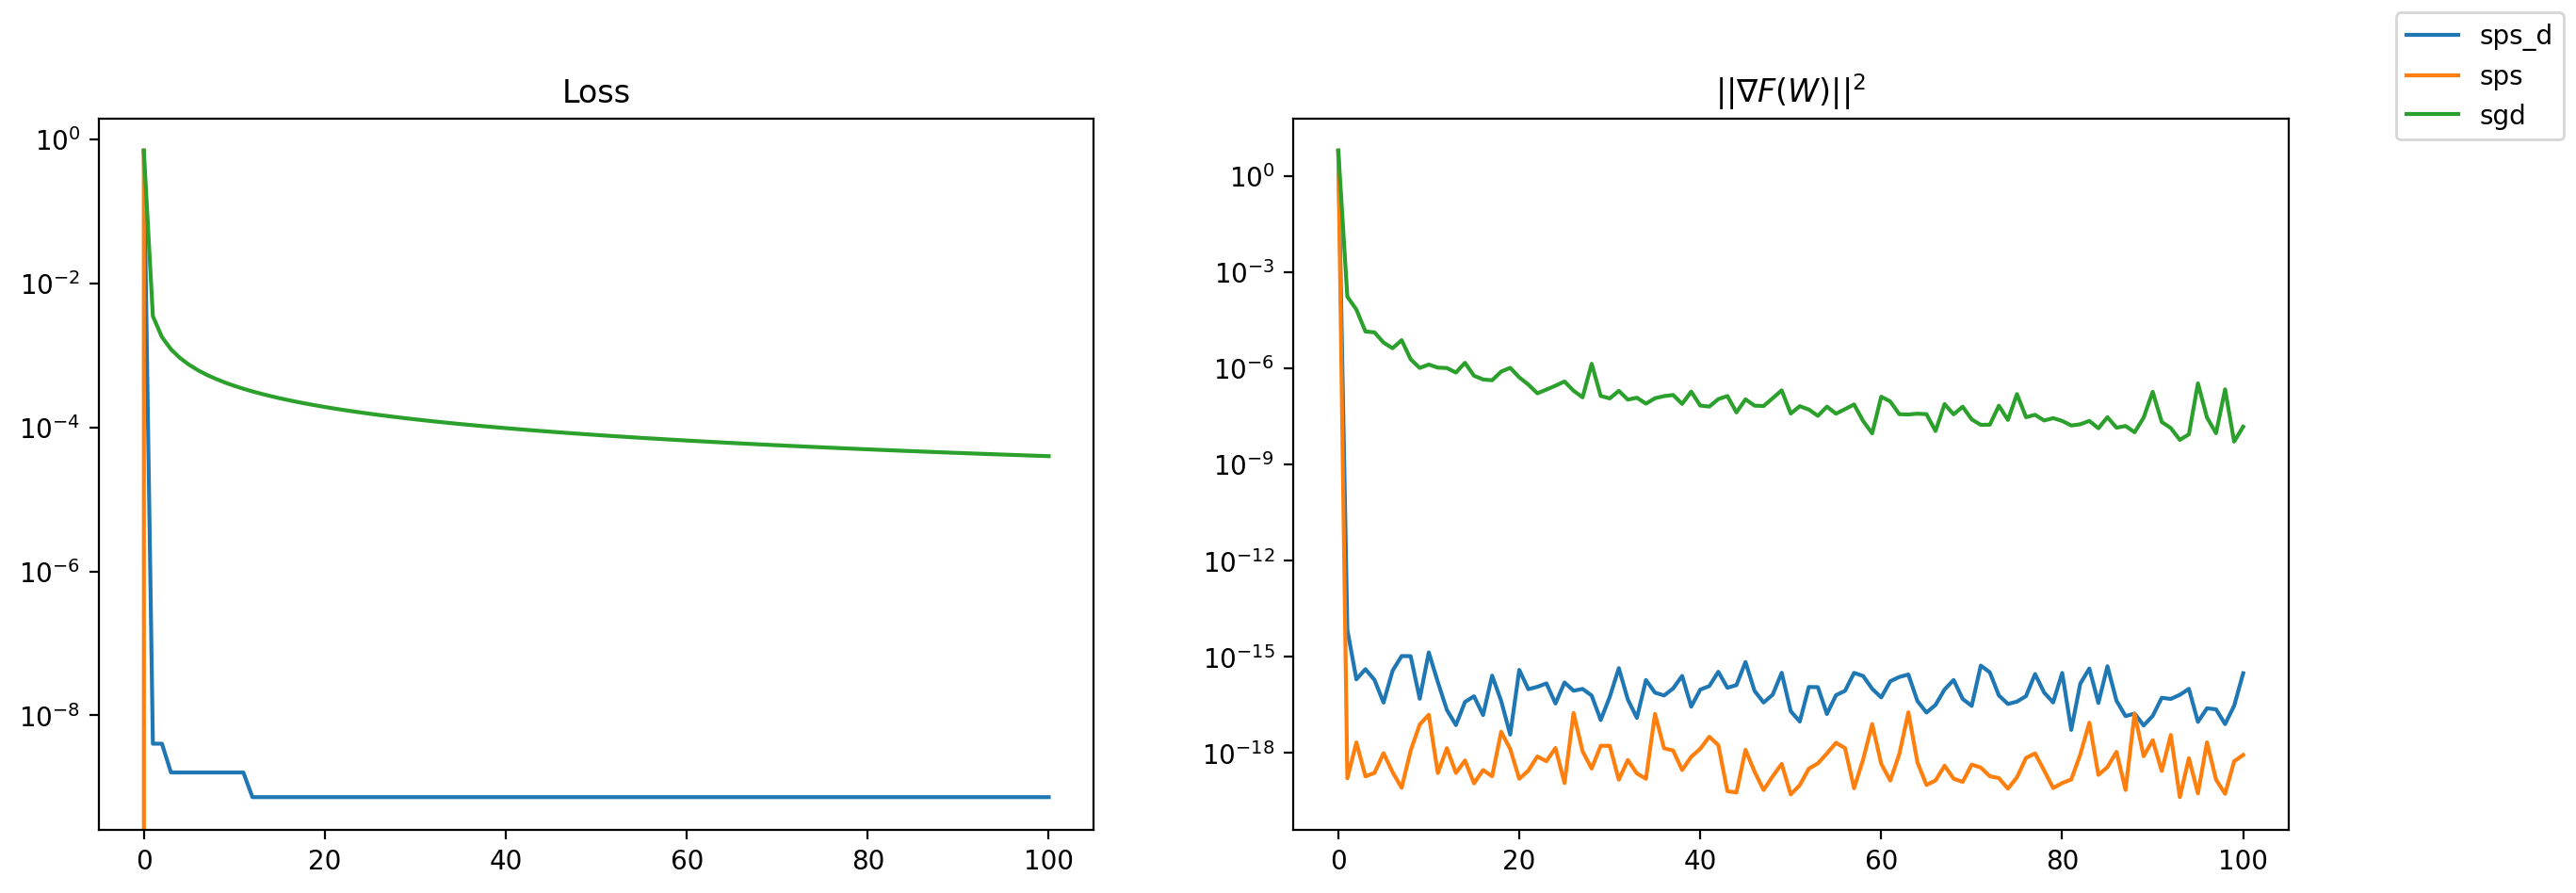

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)
ax1.plot([x[0] for x in hist_sps_d])
ax1.semilogy([x[0] for x in hist_sps])
ax1.semilogy([x[0] for x in hist_sgd])
ax1.set_title("Loss")

ax2.plot([x[1] for x in hist_sps_d])
ax2.semilogy([x[1] for x in hist_sps])
ax2.semilogy([x[1] for x in hist_sgd])
ax2.set_title(r"$\|\| \nabla F(W) \|\|^2$")

fig.legend(["sps_d", "sps", "sgd"])

# fig.savefig(f"plots/1-{dataset_name}_{loss_fn}_scale:{scale_data}.png")

# SPSL1

In [90]:
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

loss = F(w)
g, = torch.autograd.grad(loss, w, create_graph=True)

s = 0

hist_sps_l1 = [[loss.item(), (torch.linalg.norm(g) ** 2).item(), s]]

lmd = 0.01


for step in range(STEPS):
    
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
    
        loss = F(w, X=batch_data, y=batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)

        gamma_l1 = torch.max(torch.tensor(0.0), loss - s + lmd ) / (1 + torch.norm(g)**2)
        gamma = torch.min(gamma_l1, loss / (torch.norm(g)**2))

        with torch.no_grad():
            w.sub_(gamma * g)

        s = torch.max(torch.tensor(0.0), s - lmd + gamma)
        
    loss = F(w)
    g, = torch.autograd.grad(loss, w, create_graph=True) 

    print(f"Loss: {loss} | GradNorm^2: {(torch.linalg.norm(g) ** 2).item()} | S : {s}")

    hist_sps_l1.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s.item()])

Loss: 0.0284563135355711 | GradNorm^2: 0.009330136701464653 | S : 0.022053813561797142
Loss: 0.015295558609068394 | GradNorm^2: 0.0026448217686265707 | S : 0.013567278161644936
Loss: 0.010539747774600983 | GradNorm^2: 0.0012419724371284246 | S : 0.007570103742182255
Loss: 0.00806927215307951 | GradNorm^2: 0.000722265976946801 | S : 0.009135602042078972
Loss: 0.006552136968821287 | GradNorm^2: 0.00047331693349406123 | S : 0.006288854870945215
Loss: 0.00552027951925993 | GradNorm^2: 0.00033431380870752037 | S : 0.0046926261857151985
Loss: 0.004775068257004023 | GradNorm^2: 0.00024910346837714314 | S : 0.006112640257924795
Loss: 0.004209160804748535 | GradNorm^2: 0.00019286241149529815 | S : 0.004830443300306797
Loss: 0.003765675239264965 | GradNorm^2: 0.0001538750802865252 | S : 0.00353171955794096
Loss: 0.0034072061534971 | GradNorm^2: 0.0001256194373127073 | S : 0.0038818316534161568
Loss: 0.003111835103482008 | GradNorm^2: 0.00010451774869579822 | S : 0.003558218479156494
Loss: 0.0028

# SPS-L1-D

In [92]:
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

loss = F(w)
g, = torch.autograd.grad(loss, w, create_graph=True)

lmd = 0.01
s = 0

hist_sps_l1_d = [[loss.item(), (torch.linalg.norm(g) ** 2).item(), s]]


Dk = diag_estimate_old(w, g, 100)

for step in range(STEPS):
    
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        loss = F(w, X=batch_data, y=batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)

        vk = diag_estimate_old(w, g, 1)

        # Smoothing and Truncation        
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha
        Dk_hat_inv = 1 / Dk_hat

        gnorm = (g * Dk_hat_inv).dot(g)
    
        gamma_l1 = torch.max(torch.tensor(0.0), loss - s + lmd ) / (1 + (gnorm**2))
        gamma = torch.min(gamma_l1, loss / gnorm)  
        precond = gamma * Dk_hat_inv
        
        with torch.no_grad():
            w.sub_(precond * g)

        s = torch.max(torch.tensor(0.0), s - lmd + gamma)

    loss = F(w)
    g, = torch.autograd.grad(loss, w, create_graph=True) 

    print(f"Loss: {loss} | GradNorm^2: {(torch.linalg.norm(g) ** 2).item()} | S : {s}")

    hist_sps_l1_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s.item()])

Loss: 0.008329526521265507 | GradNorm^2: 0.0008106917375698686 | S : 0.00904629286378622
Loss: 0.003991276025772095 | GradNorm^2: 0.00017914647469297051 | S : 0.002994811162352562
Loss: 0.002496790373697877 | GradNorm^2: 6.855103856651112e-05 | S : 0.0021102530881762505
Loss: 0.0017425080295652151 | GradNorm^2: 3.286269202362746e-05 | S : 0.0018785344436764717
Loss: 0.0012917962158098817 | GradNorm^2: 1.784151936590206e-05 | S : 0.0014133024960756302
Loss: 0.0009975888533517718 | GradNorm^2: 1.0536579793551937e-05 | S : 0.001138770952820778
Loss: 0.0007966699777171016 | GradNorm^2: 6.666022272838745e-06 | S : 0.001038460060954094
Loss: 0.0006575171719305217 | GradNorm^2: 4.511365659709554e-06 | S : 0.0007000388577580452
Loss: 0.000559816777240485 | GradNorm^2: 3.253468548791716e-06 | S : 0.0006663696840405464
Loss: 0.00048771518049761653 | GradNorm^2: 2.4590287921455456e-06 | S : 0.00041768699884414673
Loss: 0.0004322630993556231 | GradNorm^2: 1.9248186617915053e-06 | S : 0.00049028266

# SPS-L2

In [93]:
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

loss = F(w)
g, = torch.autograd.grad(loss, w, create_graph=True)


lmd = 0.01
lmd_hat = 1.0 / (1.0 + lmd)
s = 0

hist_sps_l2 = [[loss.item(), (torch.linalg.norm(g) ** 2).item(), s]]


for step in range(STEPS):
    
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        loss = F(w, X=batch_data, y=batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)

        precond = torch.max(torch.tensor(0.0), loss - lmd_hat * s) / (torch.norm(g)**2 + lmd_hat)
    
        with torch.no_grad():
            w.sub_(precond * g)

        s = lmd_hat * (s + precond)

    loss = F(w)
    g, = torch.autograd.grad(loss, w, create_graph=True) 

    print(f"Loss: {loss} | GradNorm^2: {(torch.linalg.norm(g) ** 2).item()} | S : {s}")

    hist_sps_l2.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s.item()])

Loss: 0.10557322949171066 | GradNorm^2: 0.13834811747074127 | S : 0.12282426655292511
Loss: 0.07825339585542679 | GradNorm^2: 0.07457232475280762 | S : 0.08977823704481125
Loss: 0.0643685907125473 | GradNorm^2: 0.04995562508702278 | S : 0.07129617035388947
Loss: 0.05596407875418663 | GradNorm^2: 0.037485599517822266 | S : 0.06141437962651253
Loss: 0.04966000095009804 | GradNorm^2: 0.029344871640205383 | S : 0.06310221552848816
Loss: 0.04546235129237175 | GradNorm^2: 0.024492738768458366 | S : 0.0547056570649147
Loss: 0.042117465287446976 | GradNorm^2: 0.020953860133886337 | S : 0.045668646693229675
Loss: 0.03915536031126976 | GradNorm^2: 0.018055079504847527 | S : 0.046283893287181854
Loss: 0.03675749897956848 | GradNorm^2: 0.01586826890707016 | S : 0.04437439143657684
Loss: 0.03482842817902565 | GradNorm^2: 0.014217355288565159 | S : 0.0386357456445694
Loss: 0.03320281580090523 | GradNorm^2: 0.012895551510155201 | S : 0.03524542599916458
Loss: 0.03172573447227478 | GradNorm^2: 0.01175

# SPS-L2-D

In [94]:
w = torch.zeros(train_data.shape[1], device=device).requires_grad_()

loss = F(w)
g, = torch.autograd.grad(loss, w, create_graph=True)

lmd = 0.01
lmd_hat = 1.0 / (1.0 + lmd)
s = 0

hist_sps_l2_d = [[loss.item(), (torch.linalg.norm(g) ** 2).item(), s]]


Dk = diag_estimate_old(w, g, 100)

for step in range(STEPS):
    
    for i, (batch_data, batch_target) in enumerate(train_dataloader):
        loss = F(w, X=batch_data, y=batch_target)
        g, = torch.autograd.grad(loss, w, create_graph=True)

        vk = diag_estimate_old(w, g, 1)

        # Smoothing and Truncation        
        Dk = beta * Dk + (1 - beta) * vk
        Dk_hat = torch.abs(Dk)
        Dk_hat[Dk_hat < alpha] = alpha
        Dk_hat_inv = 1 / Dk_hat

        gnorm = (g * Dk_hat_inv).dot(g)


        gamma = torch.max(torch.tensor(0.0), loss - lmd_hat * s) / (gnorm + lmd_hat)
        precond = gamma * Dk_hat_inv
    
        with torch.no_grad():
            w.sub_(precond * g)

        s = lmd_hat * (s + gamma)

    loss = F(w)
    g, = torch.autograd.grad(loss, w, create_graph=True) 

    print(f"Loss: {loss} | GradNorm^2: {(torch.linalg.norm(g) ** 2).item()} | S : {s}")

    hist_sps_l2_d.append([loss.item(), (torch.linalg.norm(g) ** 2).item(), s.item()])

Loss: 0.05592431500554085 | GradNorm^2: 0.041232772171497345 | S : 0.06601960211992264
Loss: 0.039042163640260696 | GradNorm^2: 0.019648496061563492 | S : 0.04459463432431221
Loss: 0.02986370027065277 | GradNorm^2: 0.011219410225749016 | S : 0.03918987885117531
Loss: 0.025011638179421425 | GradNorm^2: 0.007744660601019859 | S : 0.027378318831324577
Loss: 0.021275319159030914 | GradNorm^2: 0.005523172672837973 | S : 0.023835519328713417
Loss: 0.018573477864265442 | GradNorm^2: 0.004159894771873951 | S : 0.023776181042194366
Loss: 0.016227541491389275 | GradNorm^2: 0.003135059494525194 | S : 0.025912951678037643
Loss: 0.014799360185861588 | GradNorm^2: 0.002586151473224163 | S : 0.019366072490811348
Loss: 0.01359112560749054 | GradNorm^2: 0.0021656074095517397 | S : 0.016323242336511612
Loss: 0.01257862988859415 | GradNorm^2: 0.0018435356905683875 | S : 0.015192545019090176
Loss: 0.01168926153331995 | GradNorm^2: 0.0015829468611627817 | S : 0.01549339946359396
Loss: 0.010968468151986599 

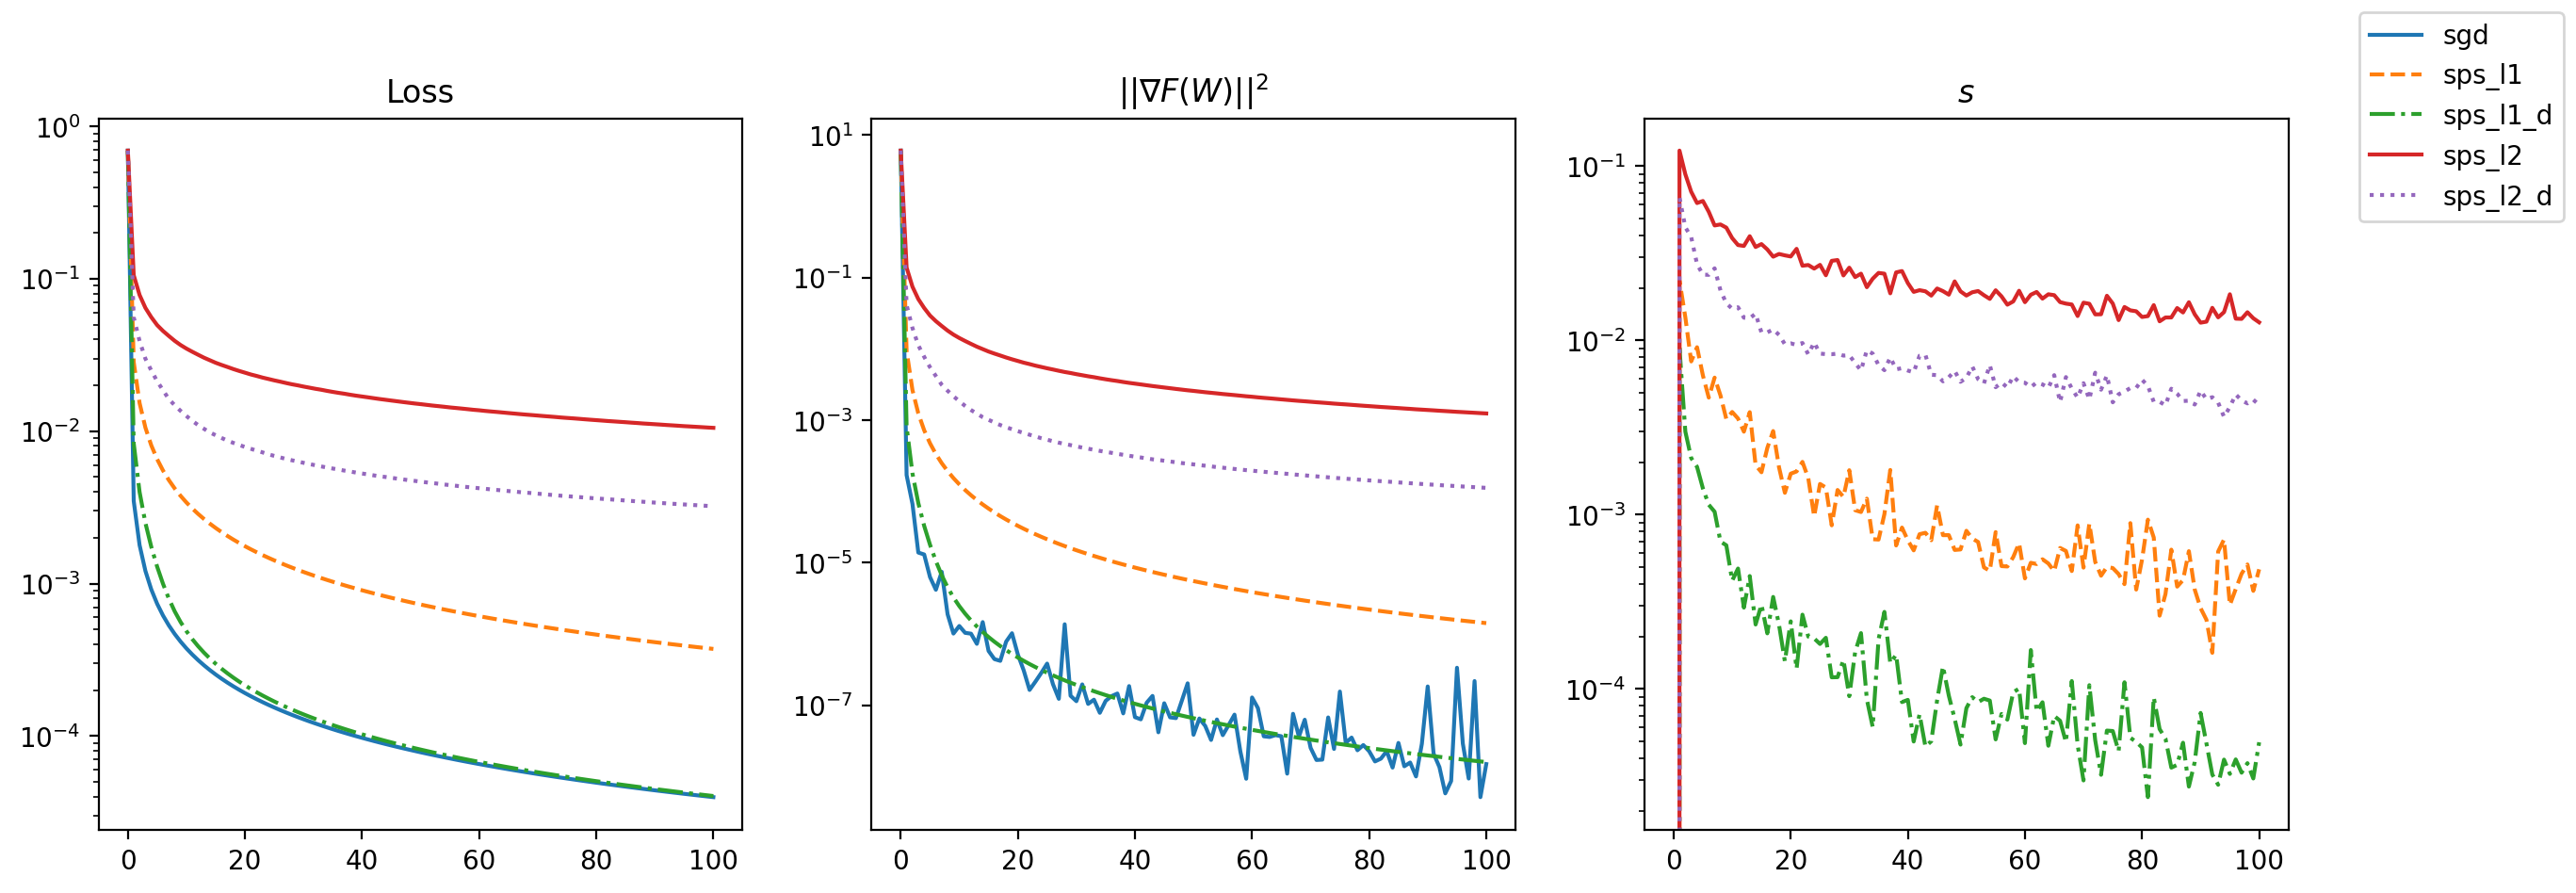

In [95]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
ax[0].semilogy([x[0] for x in hist_sgd])
ax[0].semilogy([x[0] for x in hist_sps_l1], "--")
ax[0].semilogy([x[0] for x in hist_sps_l1_d], "-.")
ax[0].semilogy([x[0] for x in hist_sps_l2])
ax[0].semilogy([x[0] for x in hist_sps_l2_d], ":")
ax[0].set_title("Loss")

ax[1].semilogy([x[1] for x in hist_sgd])
ax[1].semilogy([x[1] for x in hist_sps_l1], "--")
ax[1].semilogy([x[1] for x in hist_sps_l1_d], "-.")
ax[1].semilogy([x[1] for x in hist_sps_l2])
ax[1].semilogy([x[1] for x in hist_sps_l2_d], ":")
ax[1].set_title(r"$\|\| \nabla F(W) \|\|^2$")

ax[2].semilogy([0 for x in hist_sgd])
ax[2].semilogy([x[2] for x in hist_sps_l1], "--")
ax[2].semilogy([x[2] for x in hist_sps_l1_d], "-.")
ax[2].semilogy([x[2] for x in hist_sps_l2])
ax[2].semilogy([x[2] for x in hist_sps_l2_d], ":")
ax[2].set_title(r"$s$")


fig.legend(["sgd", "sps_l1", "sps_l1_d", "sps_l2", "sps_l2_d"])

# fig.savefig(f"plots/2-{dataset_name}_{loss_fn}_scale:{scale_data}.png")

# NN 

In [25]:
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms

In [26]:
train_dataset = torchvision.datasets.MNIST(root='./datasets', 
                                        train=True, 
                                        transform=transforms.ToTensor(),  
                                        download=True)
                                        
test_dataset = torchvision.datasets.MNIST(root='./datasets', 
                                        train=False, 
                                        transform=transforms.ToTensor()) 


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                        batch_size=batch_size, 
                                        shuffle=False) 

In [27]:
input_size = 784 # 28x28
hidden_size = 512 
num_classes = 10
num_epochs = 3
batch_size = 16
learning_rate = 0.001 

In [28]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.l2(out)
        # no activation and no softmax at the end
        return out

In [29]:
def rademacher(weights):
    return [torch.round(torch.rand_like(w)) * 2 - 1 for w in weights]

def hvp_from_grad(grads_tuple, list_params, vec_tuple):
    # don't damage grads_tuple. Grads_tuple should be calculated with create_graph=True
    dot = 0.
    for grad, vec in zip(grads_tuple, vec_tuple):
        dot += grad.mul(vec).sum()
    return torch.autograd.grad(dot, list_params, retain_graph=True)

In [56]:
class Hutch(object):

    def __init__(self):
        self.beta = 0.999
        self.alpha = 0.1

    def init(self, model, grad, iters=100):
        for group in model.param_groups:
            weights = list(group["params"])
            
            Dk = self.diag_estimate(weights, grad, iters)
            for p, Dki in zip(group['params'], Dk):
                model.state[p]['Dk'] = Dki 
        
    def step(self, model, grad, iters):
        for group in model.param_groups:
            weights = list(group["params"])
            
            vk = self.diag_estimate(weights, grad, iters)
            
            # Smoothing and Truncation 
            with torch.no_grad():
                for p, v in zip(group['params'], vk):
                    model.state[p]['Dk'].mul_(self.beta).add_(v, alpha = 1 - self.beta)
                    model.state[p]['DkhatInv'] = torch.reciprocal(torch.clamp(torch.abs(model.state[p]['Dk']), min = self.alpha))
            

    def diag_estimate(self, weights, grad, iters):
        estimates = [torch.zeros_like(w) for w in weights]
        for j in range(iters):
            rand_rad = rademacher(weights)
            hvp = hvp_from_grad(grad, weights, rand_rad)
            with torch.no_grad():
                for r, p, es in zip(rand_rad, hvp, estimates):
                    es.mul_(j/(j+1))
                    es.add_(p.detach().mul(r).div(j+1))
        return estimates


        

In [61]:
from torch.optim import Optimizer

class SPS(Optimizer):

    def __init__(self, params, preconditioner="none", slack_method="none", lmd=0.01):
        defaults = dict(s=0.0)
        self.lmd = lmd
        self.lmd_hat = 1.0 / (1.0 + self.lmd)
        
        if slack_method == "L1":
            self.update = self.update_L1
        elif slack_method == "L2":
            self.update = self.update_L2
        else:
            self.update = self.update_sps

        self.preconditioner = None
        if preconditioner == "hutch":
            self.preconditioner = Hutch()
            
        self.preconditioner_initialized = False

        # TO-DO: Think of something better
        self.replay_buffer = []

        super().__init__(params, defaults)


    def step(self, closure=None):
        for group in self.param_groups:
            weights = list(group["params"])
            
            loss = closure()
            grad = torch.autograd.grad(loss, weights, create_graph=True)
            loss = loss.item()

            if self.preconditioner:
                if not self.preconditioner_initialized:
                    self.preconditioner.init(self, grad, 100)
                    self.preconditioner_initialized = True
                self.preconditioner.step(self, grad, 1)
            else:
                self.init_empty_precond()
                self.preconditioner_initialized = True
            
            gnorm_square = self.calc_grad_norm(grad).item()
            
            if gnorm_square < 1e-13:
                continue 

            self.update(gnorm_square, loss)

            self.replay_buffer.append({
                "loss": loss,
                "grad_norm_sq": gnorm_square,
                "slack": group['s'],
            }) 
                          
        return loss

    @torch.no_grad()
    def update_sps(self, gnorm_square, loss):
        for group in self.param_groups: 
            step_size = loss / gnorm_square
            for p in group['params']:
                p.sub_(self.state[p]['scaled_grad'].mul(step_size))
    

    @torch.no_grad()
    def update_L1(self, gnorm_square, loss):

            for group in self.param_groups:
                s = group['s']
                step_size_temp = torch.max(
                    torch.tensor(0.0), torch.tensor(loss - s + self.lmd) ) / (1 + gnorm_square)

                step_size = torch.min(step_size_temp, torch.tensor(loss / gnorm_square))

                group['s'] = torch.max(torch.tensor(0.0), 
                torch.tensor(s - self.lmd + step_size_temp))

                for p in group['params']:
                    p.sub_(self.state[p]['scaled_grad'].mul(step_size))

    @torch.no_grad()
    def update_L2(self, gnorm_square ,loss):
        
        for group in self.param_groups: 
            s = group['s']
            step_size = torch.max(torch.tensor(0.0), torch.tensor(loss - self.lmd_hat * s)) / (gnorm_square + self.lmd_hat)
            group['s'] = self.lmd_hat * (s + step_size)

            for p in group['params']:
                p.sub_(self.state[p]['scaled_grad'].mul(step_size))
            

    def init_empty_precond(self):
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['Dk'] = torch.ones_like(p) 
                self.state[p]['DkhatInv'] = torch.ones_like(p)

    def calc_grad_norm(self, grad):
        for group in self.param_groups: 
            gnorm_square = 0.
            for p, g in zip(group['params'], grad):
                g_detached = g.detach().clone()
                self.state[p]['scaled_grad'] = self.state[p]['DkhatInv'].mul(g_detached)
                gnorm_sq = self.state[p]['scaled_grad'].mul(g_detached).sum()
                gnorm_square += gnorm_sq

        return gnorm_square



In [62]:
@torch.no_grad()
def eval_model(model, loss_fn, data_loader):
    n_correct = 0
    n_samples = 0
    loss = 0
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss += loss_fn(outputs, labels).item() / len(data_loader)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()  
    
    acc = 100.0 * n_correct / n_samples

    return loss, acc

In [98]:
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = SPS(model.parameters()) 

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

n_total_steps = len(train_loader)

nn_train_hist = []
nn_test_hist = []

for epoch in range(num_epochs):
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        def closure():
            optimizer.zero_grad()
            outputs = model(images)
            return criterion(outputs, labels)
        
        loss = closure()

        if isinstance(optimizer, SPS):     
                  
            optimizer.step(closure) 
        else:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss = optimizer.replay_buffer[-1]["loss"]

        if (i+1) % 100 == 0:
            print (f'Step[{i+1}/{n_total_steps}], Loss: {loss}') 


    with torch.no_grad():
        train_loss, train_acc = eval_model(model, criterion, train_loader) 
        print(f"Train Loss: {train_loss} | Train Acc: {train_acc}")

        test_loss, test_acc = eval_model(model, criterion, test_loader)
        print(f"Train Loss: {test_loss} | Train Acc: {test_acc}")

        nn_train_hist.append([train_loss, train_acc])
        nn_test_hist.append([test_loss, test_acc])



Epoch [1/3]
Step[100/3750], Loss: 1.2589794397354126
Step[200/3750], Loss: 0.2791561186313629
Step[300/3750], Loss: 1.350012183189392
Step[400/3750], Loss: 0.13339665532112122
Step[500/3750], Loss: 0.48646819591522217
Step[600/3750], Loss: 0.28245094418525696
Step[700/3750], Loss: 0.8401963114738464
Step[800/3750], Loss: 0.1328917145729065
Step[900/3750], Loss: 0.3595355153083801
Step[1000/3750], Loss: 0.2864590585231781
Step[1100/3750], Loss: 0.37062549591064453
Step[1200/3750], Loss: 0.21050649881362915
Step[1300/3750], Loss: 0.07949293404817581
Step[1400/3750], Loss: 0.10497119277715683
Step[1500/3750], Loss: 0.07509759813547134
Step[1600/3750], Loss: 0.04631654545664787
Step[1700/3750], Loss: 0.19889822602272034
Step[1800/3750], Loss: 0.40841159224510193
Step[1900/3750], Loss: 0.358713835477829
Step[2000/3750], Loss: 0.3988208770751953
Step[2100/3750], Loss: 0.5637558698654175
Step[2200/3750], Loss: 0.3377033472061157
Step[2300/3750], Loss: 0.31136760115623474
Step[2400/3750], Loss

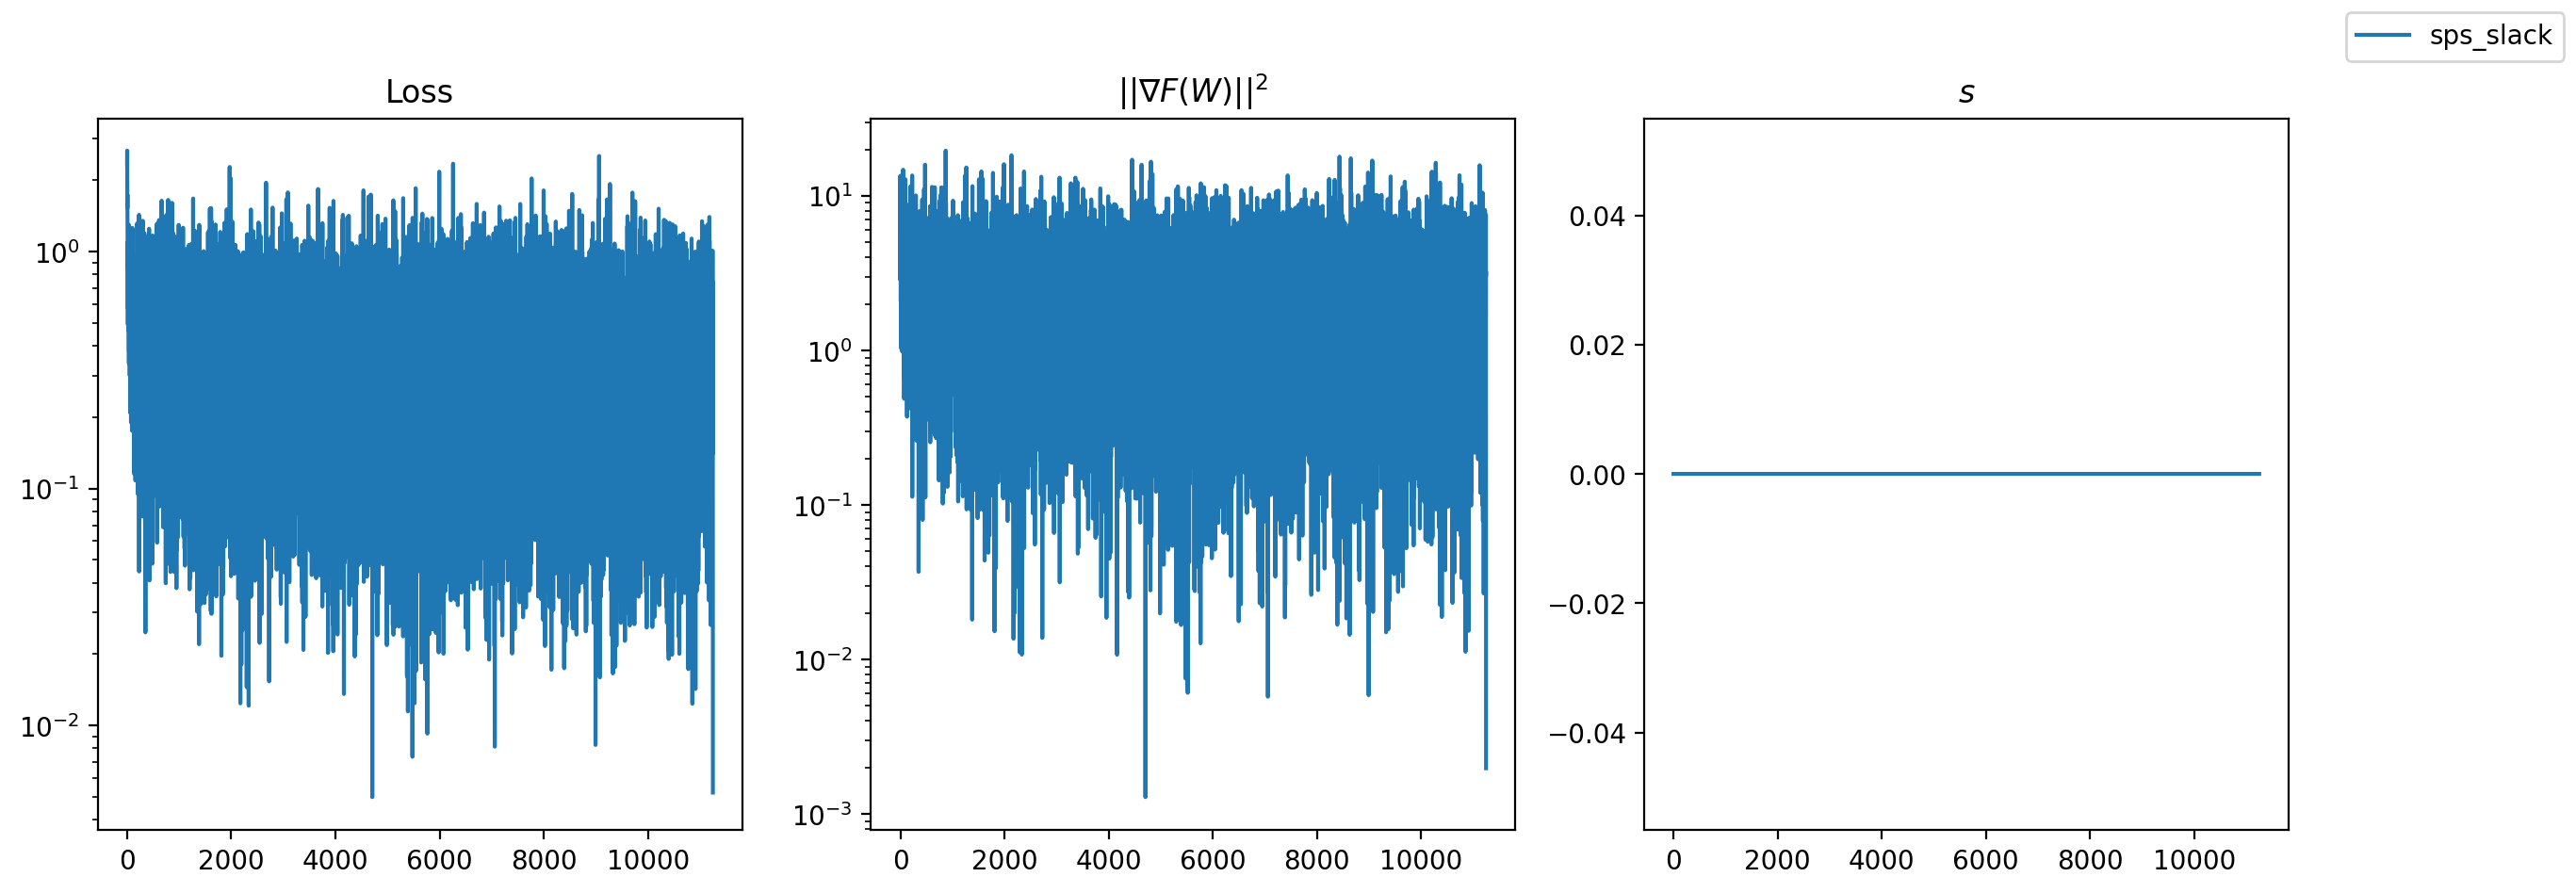

In [102]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), dpi=200)
replay = optimizer.replay_buffer

ax[0].semilogy([x["loss"] for x in replay])
ax[0].set_title("Loss")

ax[1].semilogy([x["grad_norm_sq"] for x in replay])
ax[1].set_title(r"$\|\| \nabla F(W) \|\|^2$")

ax[2].plot([x["slack"] for x in replay])
ax[2].set_title(r"$s$")

fig.legend(["sps_slack"]) 

In [78]:
def Rosenbrock(xy):
    x, y = xy
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

def Rastrigin(xy):
    x, y = xy
    pi = torch.tensor(3.141592)
    A = 10
    return A * 2 + ((x**2 - A * torch.cos(2 * pi * x)) + (y**2 - A * torch.cos(2 * pi * y)))


In [79]:
def run_optimizer(xy_init, optimizer_class, loss_fn, iters, **optimizer_kwargs):

    xy = torch.tensor(xy_init, requires_grad=True)

    # optimizer = SPS([xy], preconditioner="none", slack_method="none")
    optimizer = optimizer_class([xy], **optimizer_kwargs)
    
    path = np.empty((iters + 1, 2))
    for step in range(iters):
            
            def closure():
                optimizer.zero_grad()
                return loss_fn(xy)
            
            loss = closure()

            if isinstance(optimizer, SPS):     
                optimizer.step(closure) 
            else:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            

            path[step, :] = xy.detach().numpy()

    return path

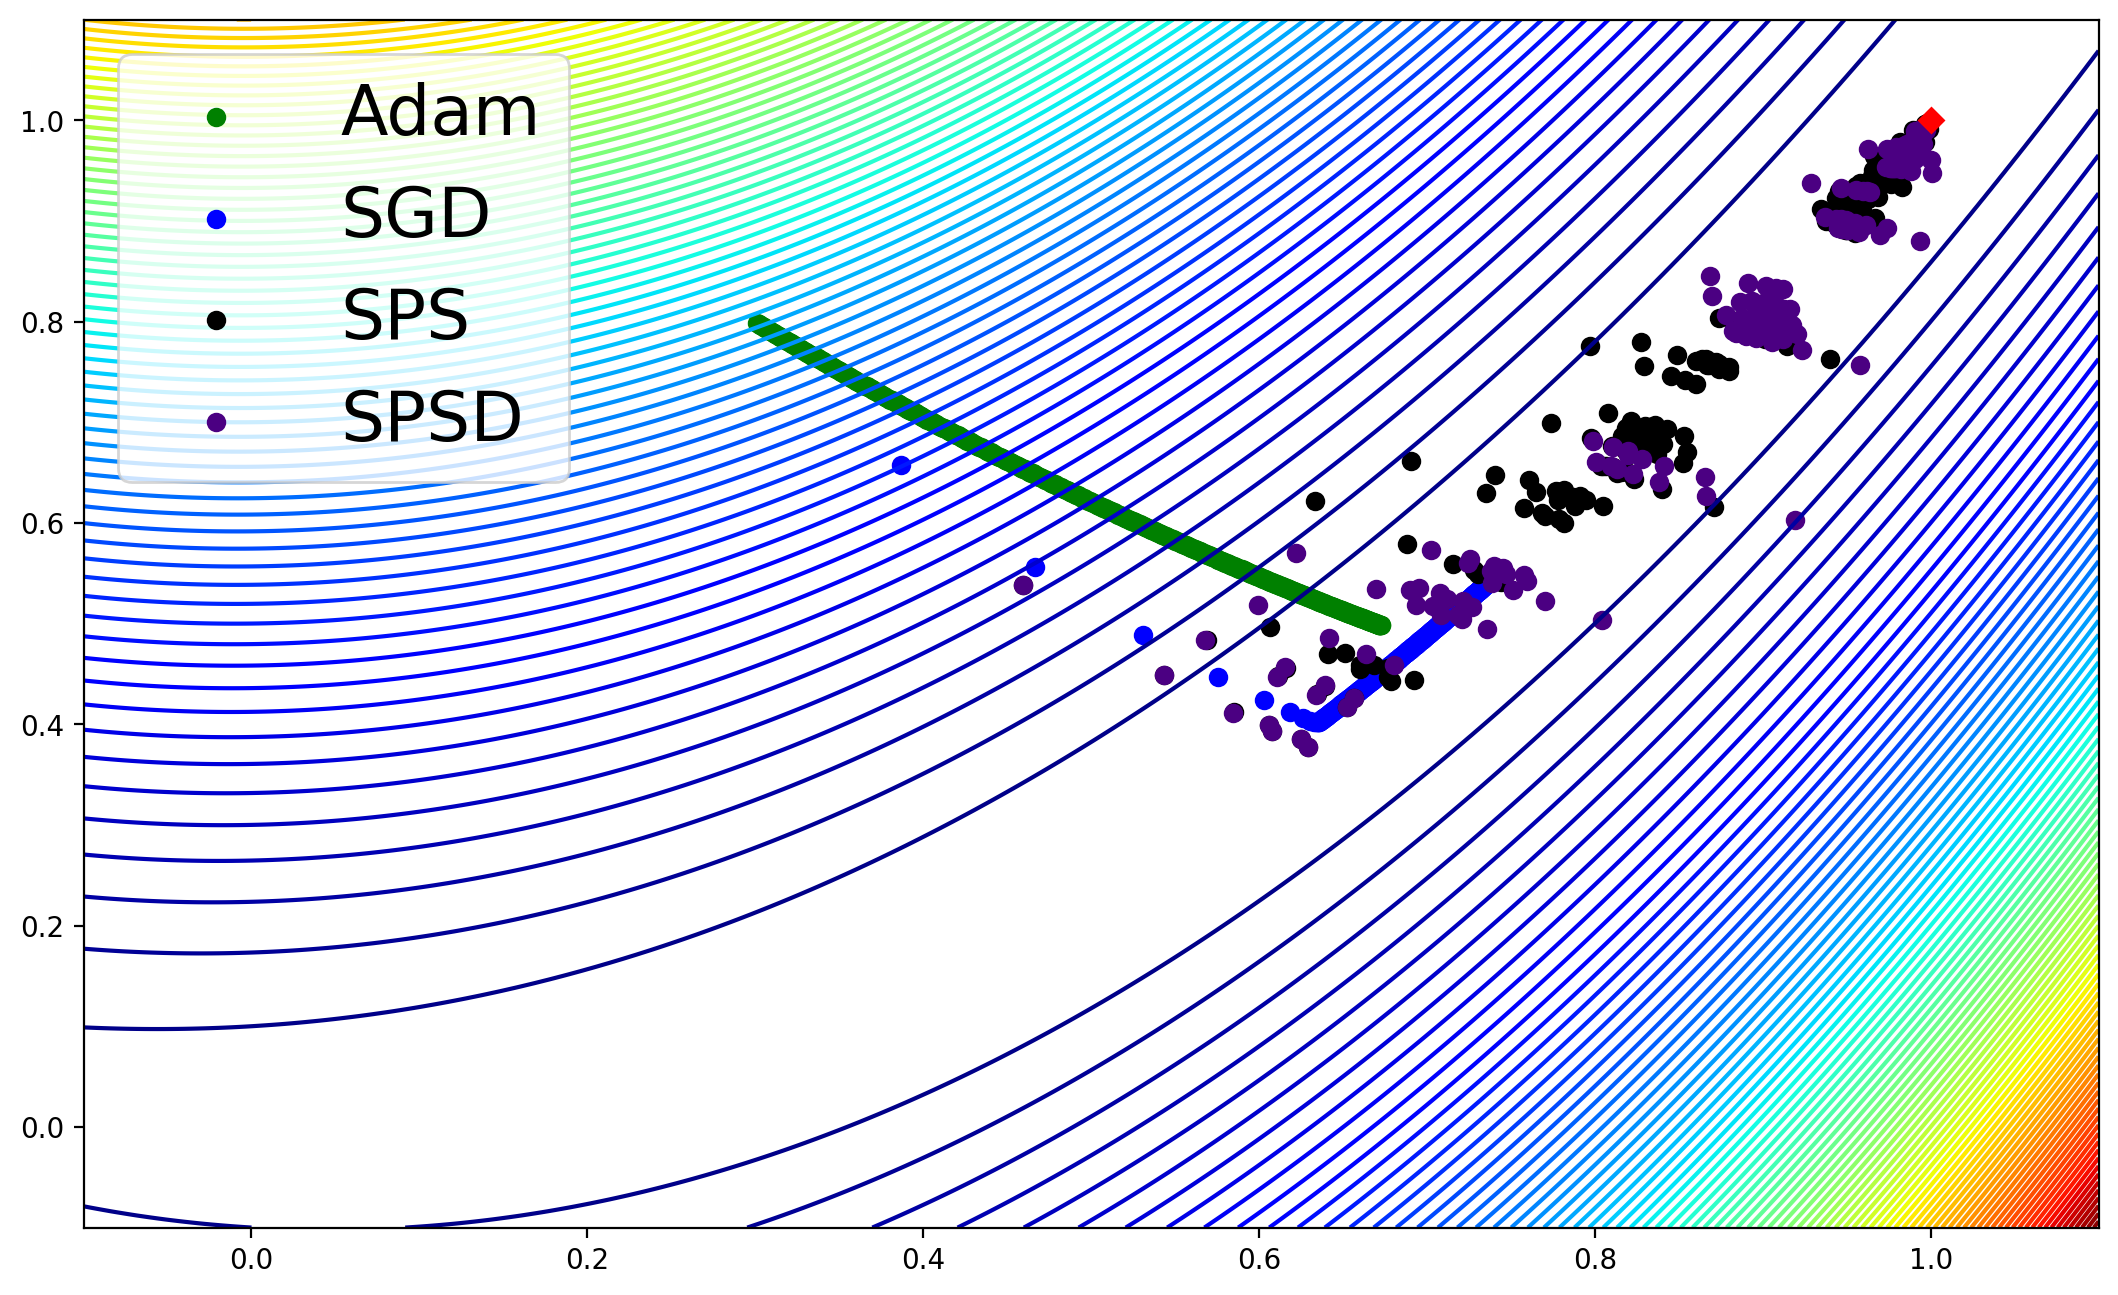

In [90]:
from torch.optim import Adam, SGD

# optimizer = SPS([xy], preconditioner="none", slack_method="none")

xy_init = (.3, .8)  
n_iter = 1500

loss_fn = Rosenbrock
y_lim = (-.1, 1.1)
x_lim = (-.1, 1.1)

path_adam = run_optimizer(xy_init, Adam, loss_fn, n_iter)
path_sgd = run_optimizer(xy_init, SGD, loss_fn, n_iter, lr=1e-3)
path_sps = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="none", slack_method="none")
path_sps_d = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="hutch", slack_method="none")


paths = [path_adam, path_sgd, path_sps, path_sps_d]
colors = ["green", "blue", "black", "indigo"]
names = ["Adam", "SGD", "SPS", "SPSD"]


n_points = 300

x = np.linspace(*x_lim, n_points)
y = np.linspace(*y_lim, n_points)
X, Y = np.meshgrid(x, y)
Z = Rosenbrock([X, Y])

minimum = (1.0, 1.0)

fig, ax = plt.subplots(figsize=(13, 8), dpi=200)
ax.contour(X, Y, Z, 90, cmap="jet")

scatters = [ax.scatter(None,
                        None,
                        label=label,
                        c=c) for c, label in zip(colors, names)]

for path, scatter in zip(paths, scatters):
        scatter.set_offsets(path[:i, :])

        # ax.set_title(str(i))


ax.legend(prop={"size": 25})
ax.plot(*minimum, "rD")



/tmp/ipykernel_3592964/1899358829.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s - self.lmd + step_size_temp))
/tmp/ipykernel_3592964/1899358829.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(0.0), torch.tensor(loss - s + self.lmd) ) / (1 + gnorm_square)
/tmp/ipykernel_3592964/1899358829.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  step_size = torch.max(torch.tensor(0.0), torch.tensor(loss - self.lmd_hat * s)) / (gnorm_square + self.lmd_hat)


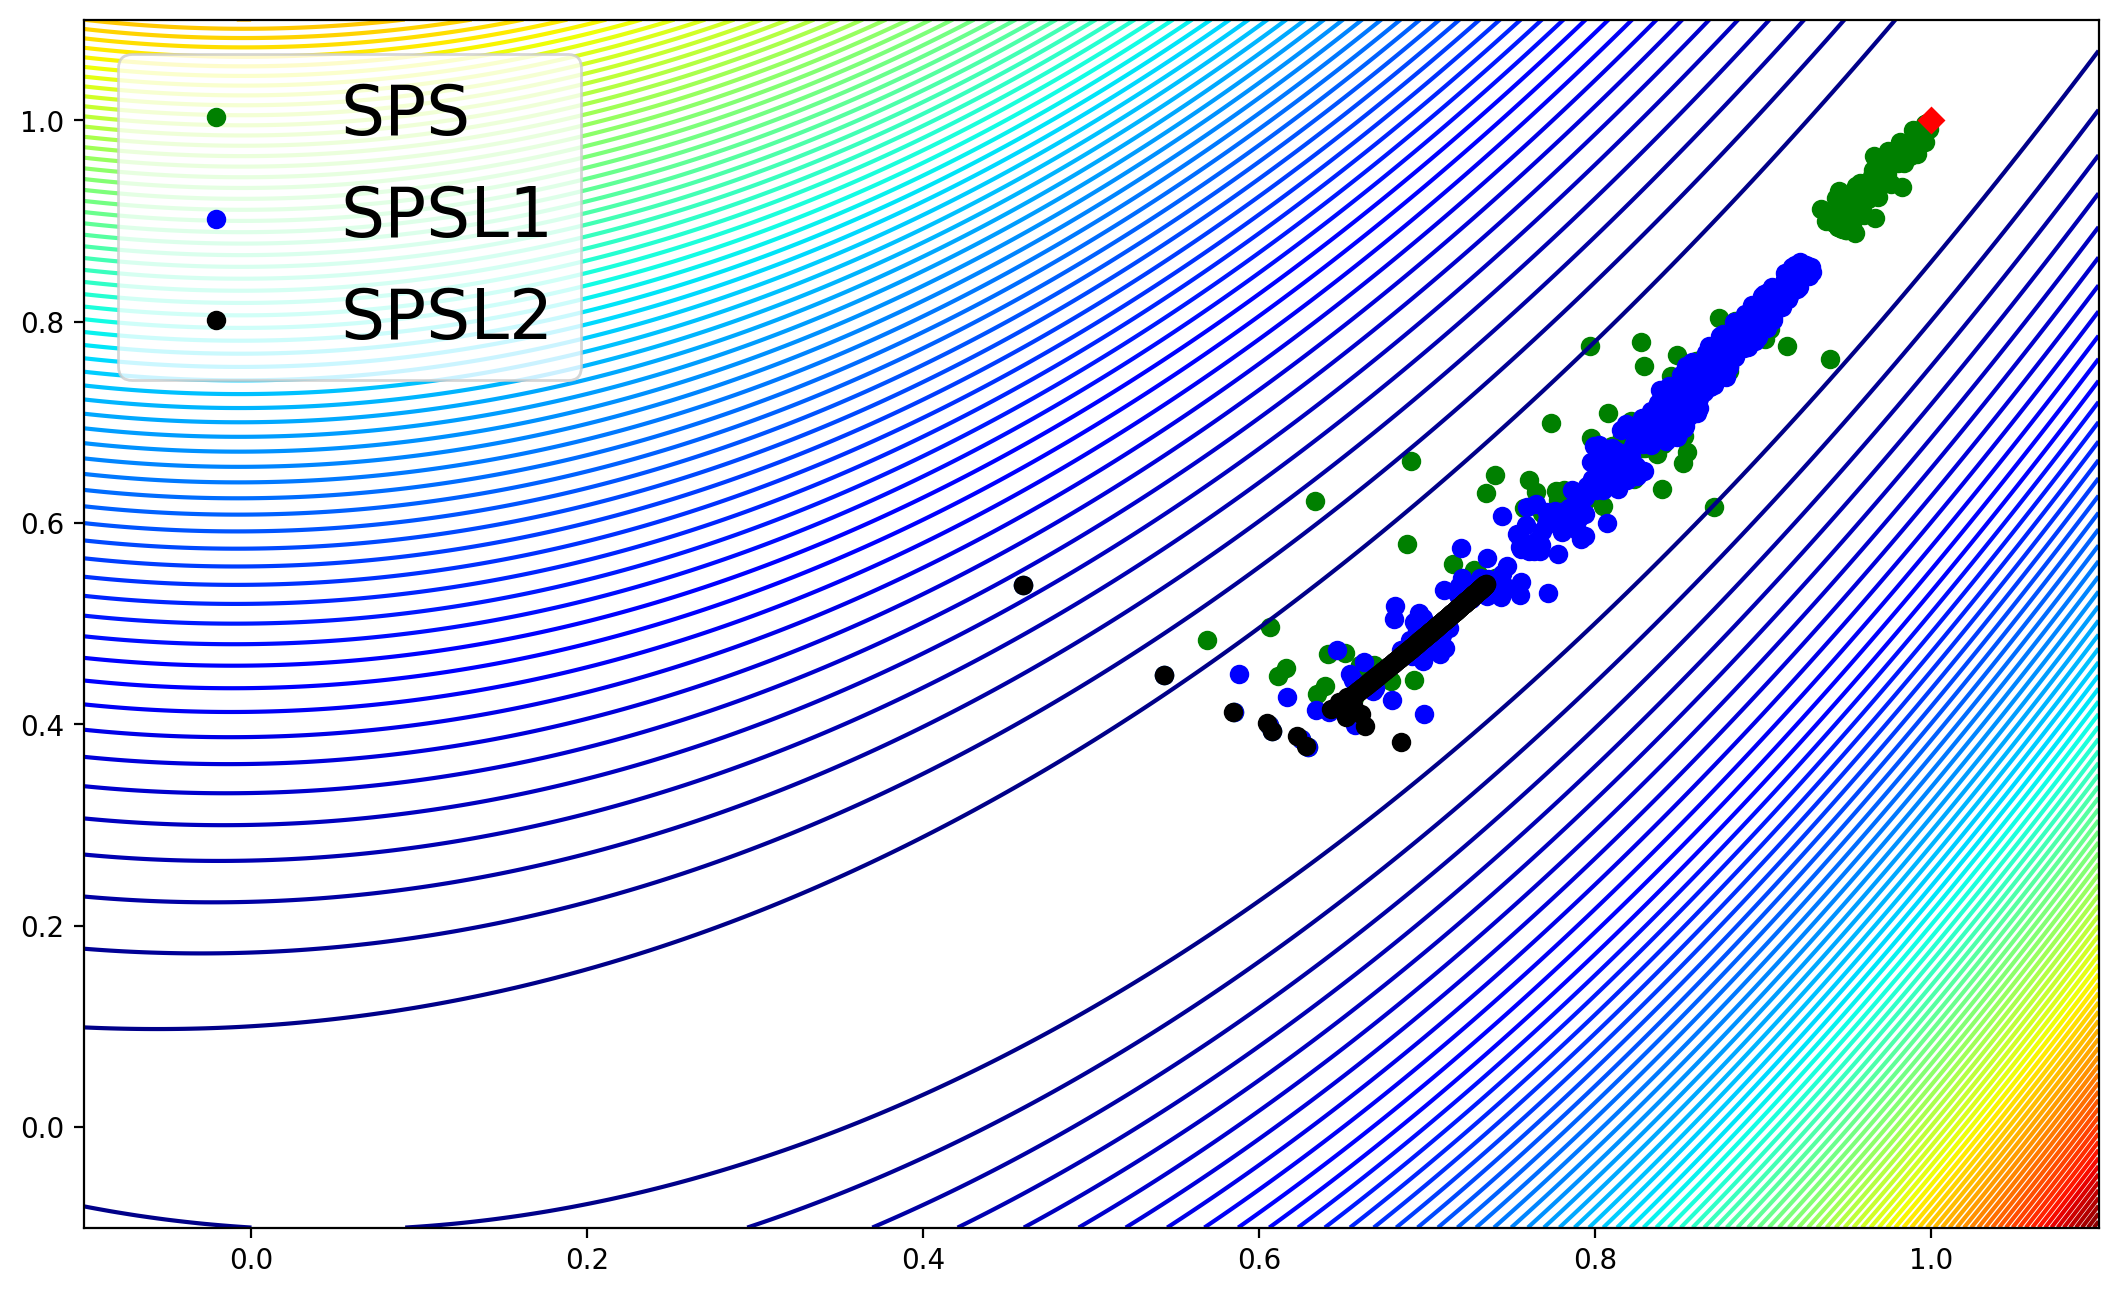

In [81]:
xy_init = (.3, .8)  
n_iter = 1500

path_sps = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="none", slack_method="none")
path_sps_l1 = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="none", slack_method="L1")
path_sps_l2 = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="none", slack_method="L2")


paths = [path_sps, path_sps_l1, path_sps_l2]
colors = ["green", "blue", "black", "indigo"]
names = ["SPS", "SPSL1", "SPSL2"]


n_points = 300
x = np.linspace(-0.1, 1.1, n_points)
y = np.linspace(-0.1, 1.1, n_points)
X, Y = np.meshgrid(x, y)
Z = Rosenbrock([X, Y])

minimum = (1.0, 1.0)

fig, ax = plt.subplots(figsize=(13, 8), dpi=200)
ax.contour(X, Y, Z, 90, cmap="jet")

scatters = [ax.scatter(None,
                        None,
                        label=label,
                        c=c) for c, label in zip(colors, names)]

for path, scatter in zip(paths, scatters):
        scatter.set_offsets(path[:i, :])

        # ax.set_title(str(i))


ax.legend(prop={"size": 25})
ax.plot(*minimum, "rD")



/tmp/ipykernel_3592964/1899358829.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(s - self.lmd + step_size_temp))
/tmp/ipykernel_3592964/1899358829.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(0.0), torch.tensor(loss - s + self.lmd) ) / (1 + gnorm_square)
/tmp/ipykernel_3592964/1899358829.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  step_size = torch.max(torch.tensor(0.0), torch.tensor(loss - self.lmd_hat * s)) / (gnorm_square + self.lmd_hat)


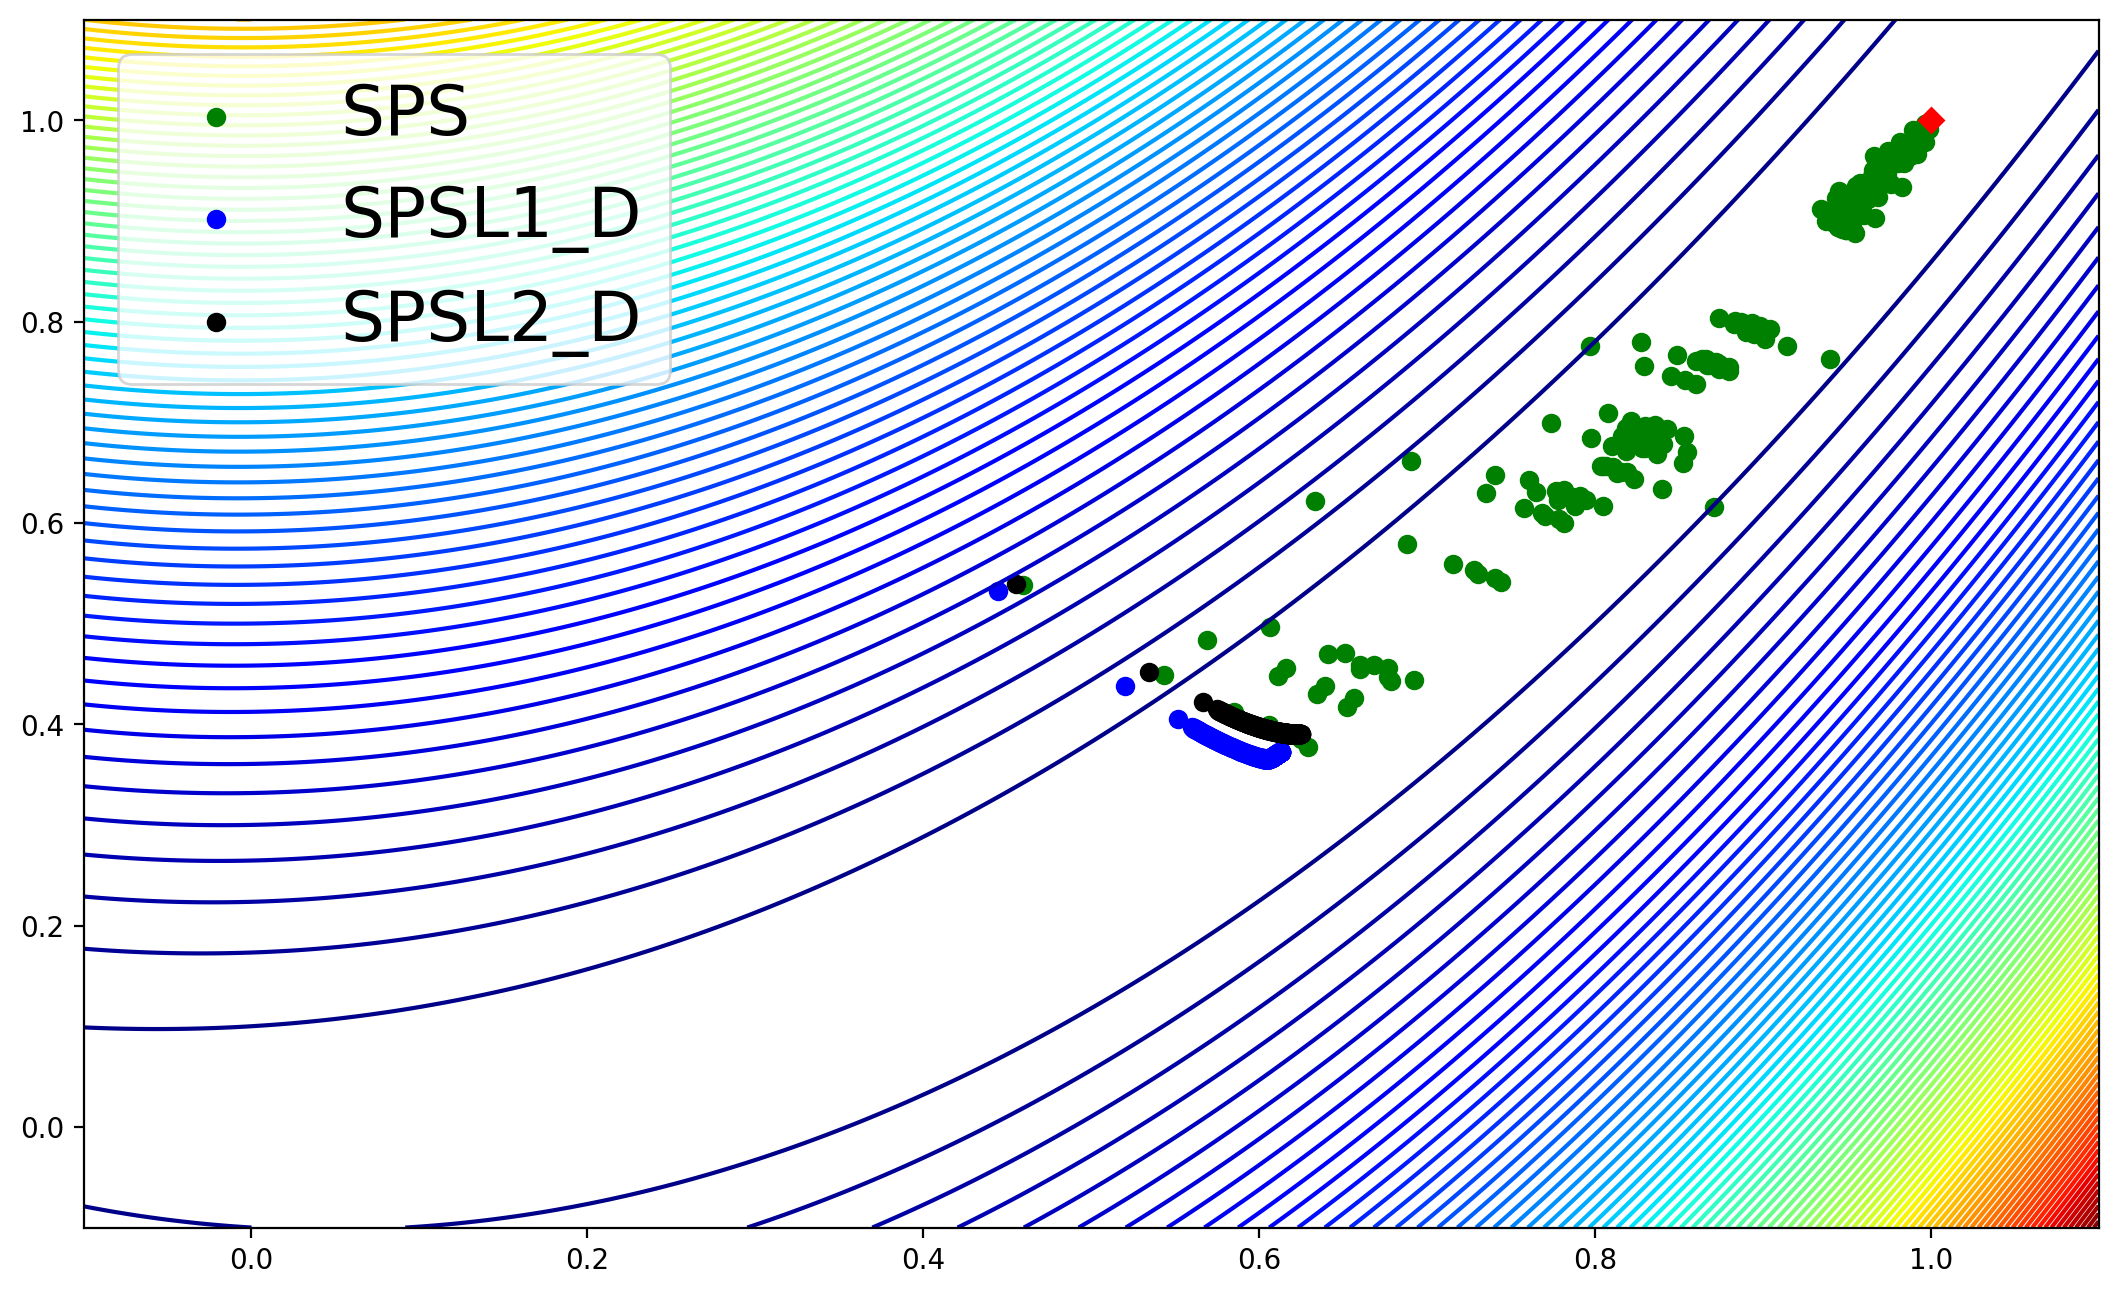

In [84]:
xy_init = (.3, .8)  
n_iter = 1500

path_sps = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="none", slack_method="none")
path_sps_l1_d = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="hutch", slack_method="L1")
path_sps_l2_d = run_optimizer(xy_init, SPS, loss_fn, n_iter, preconditioner="hutch", slack_method="L2")


paths = [path_sps, path_sps_l1_d, path_sps_l2_d]
colors = ["green", "blue", "black", "indigo"]
names = ["SPS", "SPSL1_D", "SPSL2_D"]


n_points = 300
x = np.linspace(-0.1, 1.1, n_points)
y = np.linspace(-0.1, 1.1, n_points)
X, Y = np.meshgrid(x, y)
Z = Rosenbrock([X, Y])

minimum = (1.0, 1.0)

fig, ax = plt.subplots(figsize=(13, 8), dpi=200)
ax.contour(X, Y, Z, 90, cmap="jet")

scatters = [ax.scatter(None,
                        None,
                        label=label,
                        c=c) for c, label in zip(colors, names)]

for path, scatter in zip(paths, scatters):
        scatter.set_offsets(path[:i, :])

        # ax.set_title(str(i))


ax.legend(prop={"size": 25})
ax.plot(*minimum, "rD")



In [ ]:
1. Train LeNet and "model" on MNIST
2. 